In [1]:
import argparse
import collections
import torch.optim as optim
from torchvision import transforms
from retinanet import model
# from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter,Normalizer
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter,UnNormalizer, Normalizer
from torch.utils.data import DataLoader
from retinanet import coco_eval
from retinanet import csv_eval
import torch
import copy
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings 
import json
from torch.utils.data.sampler import SubsetRandomSampler
import retinanet.model as retinanet_model
warnings.filterwarnings("ignore")

assert torch.__version__.split('.')[0] == '1'

print('CUDA available: {}'.format(torch.cuda.is_available()))


CUDA available: True


In [2]:
# Reference : https://github.com/qqadssp/RetinaNet-Pytorch/blob/master/utils/utils.py
def box_iou(box1, box2, order='xyxy'):
    '''Compute the intersection over union of two set of boxes.
    The default box order is (xmin, ymin, xmax, ymax).
    Args:
      box1: (tensor) bounding boxes, sized [N,4].
      box2: (tensor) bounding boxes, sized [M,4].
      order: (str) box order, either 'xyxy' or 'xywh'.
    Return:
      (tensor) iou, sized [N,M].
    Reference:
      https://github.com/chainer/chainercv/blob/master/chainercv/utils/bbox/bbox_iou.py
    '''
    if order == 'xywh':
        box1 = change_box_order(box1, 'xywh2xyxy')
        box2 = change_box_order(box2, 'xywh2xyxy')

    N = box1.size(0)
#     print(box1,box2)
    M = box2.size(0)

    lt = torch.max(box1[:,None,:2], box2[:,:2])  # [N,M,2]
    rb = torch.min(box1[:,None,2:], box2[:,2:])  # [N,M,2]

    wh = (rb-lt+1).clamp(min=0)      # [N,M,2]
    inter = wh[:,:,0] * wh[:,:,1]  # [N,M]

    area1 = (box1[:,2]-box1[:,0]+1) * (box1[:,3]-box1[:,1]+1)  # [N,]
    area2 = (box2[:,2]-box2[:,0]+1) * (box2[:,3]-box2[:,1]+1)  # [M,]
    iou = inter / (area1[:,None] + area2 - inter)
    return iou

In [3]:
def get_bbox(annotations,address):
    return np.array(annotations)[list(np.array(annotations['image_id'])).index(address)][2]

def draw_caption(image, box, caption):

    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)

In [4]:
# test_json_loc = sys.argv[1]
# test_csv_file = sys.argv[2]
# model_loc = sys.argv[3]
test_json_loc = "../train_annotations.json"
test_csv_file = "mytestdata.csv"
test_data_path = './final_test_data/'
# model_loc = "./Best_model/model_final.pt"
model_loc = "./model_final_2.pt"

In [5]:
f= open(test_json_loc,"r")
g = f.read()
annotations_dict = json.loads(g)
annotations = pd.DataFrame(annotations_dict['annotations'])

In [6]:
# f = open("class_detail1.csv","r")
# g = f.read().split("\n")
# dict_labels = {}
# for i in g:
#     dict_labels[i.split(",")[0]] = int(i.split(",")[1])


In [7]:
dict_labels = {'coyote': 0,
 'bobcat': 1,
 'bird': 2,
 'raccoon': 3,
 'car': 4,
 'rabbit': 5,
 'squirrel': 6,
 'cat': 7}

In [8]:
list_class = os.listdir(test_data_path)
# dict_labels,labels = mapping(list_class)

dataset = []
class_ = []
bbox = []
label_main = []
paths = []
class_name = []
counter_except = 0
count_label = []
for i in range(len(list_class)):
    list_classwise = os.listdir(test_data_path+list_class[i])
    count_label.append(len(list_classwise))
    for j in list_classwise:
        img = cv2.imread(test_data_path+list_class[i]+"/"+j,1)
        try:
            box = get_bbox(annotations,j.split('.')[0])
            bbox.append(box)
            img = cv2.resize(img,(100,100))
            img = np.swapaxes(img,0,2).flatten()
            
            paths.append(test_data_path+list_class[i]+"/"+j)
            class_name.append(list_class[i])
            label_main.append(dict_labels[list_class[i]])
            dataset.append(img)
            class_.append(i)
        except:
            counter_except = counter_except +1

In [9]:
count_label = []
for i in range(len(list_class)):
    list_classwise = os.listdir(test_data_path+list_class[i])
    count_label.append(len(list_classwise))

In [ ]:
# Making the csv file  for testing data
f = open(test_csv_file,"w")
for i in range(len(paths)):
    f = open(test_csv_file,"a")
    f.write(paths[i])
    f.write(",")
    try:
        f.write(str(int(bbox[i][0])))
    except:
        pass
    f.write(",")
    try:
        f.write(str(int(bbox[i][1])))
    except:
        pass
    f.write(",")
    try:
        f.write(str(int(bbox[i][0])+int(bbox[i][3])))
    except:
        pass
    f.write(",")
    try:  
        f.write(str(int(bbox[i][1]) + int(bbox[i][2])))
    except:
        pass
    f.write(",")
    
    f.write(class_name[i])
    f.write("\n")
    f.close()

In [ ]:
# dataset_val = CSVDataset(train_file="./myvaliddataset.csv", class_list="./class_detail.csv",
#                                  transform=transforms.Compose([Normalizer(), Resizer()]))
# sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=4,drop_last=False)
# dataloader_val = DataLoader(dataset_val, num_workers=3, collate_fn=collater, batch_sampler=sampler_val)

In [ ]:
# retinanet = torch.load("../pretrained_weights.pt")

In [ ]:
# epochs =100

In [10]:
# dataset_train = CSVDataset(train_file="./mytraindataset.csv", class_list="./class_detail.csv",
#                                transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
dataset_val = CSVDataset(train_file=test_csv_file, class_list="./class_detail.csv",
                                 transform=transforms.Compose([Normalizer(), Resizer()]))

In [11]:
# sampler = AspectRatioBasedSampler(dataset_train, batch_size=8, drop_last=False)
# dataloader_train = DataLoader(dataset_train, num_workers=3, collate_fn=collater, batch_sampler=sampler)

if dataset_val is not None:
    sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
    dataloader_val = DataLoader(dataset_val, num_workers=3, collate_fn=collater, batch_sampler=sampler_val)

# Create the model

# retinanet = model.resnet50(num_classes=8)
retinanet = torch.load(model_loc)
use_gpu = True



In [12]:
# Initialising the checkpoint 
num_classes = 8

# for param in retinanet.parameters():
#     param.requires_grad = False
# retinanet.classificationModel.fc = nn.Linear(720, num_classes)
# retinanet = retinanet_model.resnet50(80)
# checkpoint = torch.load(model_loc)
# retinanet.load_state_dict(checkpoint)
if use_gpu:
    retinanet = retinanet.cuda()
# print("Model retinanet : ",retinanet)
retinanet = torch.nn.DataParallel(retinanet).cuda()
# retinanet.training = True
# optimizer = optim.Adam(retinanet.parameters(), lr=1e-5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
# loss_hist = collections.deque(maxlen=500)
# retinanet.train()
# retinanet.module.freeze_bn()



In [13]:
print('Num test images: {}'.format(len(dataset_val)))
retinanet.eval()
mAP = csv_eval.evaluate(dataset_val, retinanet)

Num test images: 400
400/400
mAP:
coyote: 0.4672927848710474
bobcat: 0.49628339368969443
bird: 0.2760479915276912
raccoon: 0.8026216864368125
car: 1.0
rabbit: 0.7234794118025578
squirrel: 0.4324337827374148
cat: 0.6106827749462234


In [14]:

unnormalize = UnNormalizer()
iou_total = []
coor_pred = []
coor_true = []
true_label = []
pred_label = []
for idx, data in enumerate(dataloader_val):
    with torch.no_grad():
        
        scores, classification, transformed_anchors = retinanet(data['img'].cuda().float())
        idxs = np.where(scores.cpu()>0.5)
        img = np.array(255 * unnormalize(data['img'][0, :, :, :])).copy()

        img[img<0] = 0
        img[img>255] = 255

        img = np.transpose(img, (1, 2, 0))

        img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
        temp = []
        temp1 = []
        for j in range(idxs[0].shape[0]):
            
            bbox = transformed_anchors[idxs[0][j], :]
            x1 = int(bbox[0])
            y1 = int(bbox[1])
            x2 = int(bbox[2])
            y2 = int(bbox[3])
            temp.append([x1,y1,x2,y2])
            label_name = dataset_val.labels[int(classification[idxs[0][j]])]
            temp1.append(label_name)
            draw_caption(img, (x1, y1, x2, y2), label_name)
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)
        true_annot = data["annot"]
        coor_pred.append(temp)
        pred_label.append(temp1)
        iou = 0
        temp = []
        temp1 = []
        for i in range(len(true_annot)):
            temp = []
            temp1 = []
            for k in range(len(true_annot[0])):
                    
                a1 = int(true_annot[i][k][0])
                a2 = int(true_annot[i][k][1])
                a3 = int(true_annot[i][k][2])
                a4 = int(true_annot[i][k][3])
                
                lab = dataset_val.labels[int(true_annot[0][0][4])]
                temp.append([a1,a2,a3,a4])
                temp1.append(lab)
                draw_caption(img, (a1, a2, a3, a4), lab)
        
                cv2.rectangle(img, (a1, a2), (a3, a4), color=(0, 255,0), thickness=2)
                
            coor_true.append(temp)
            true_label.append(temp1)
        
        
#             print(label_name)
#         print(idx)
#         cv2.imwrite("./test_pred/"+"img_"+label_name+str(idx)+".jpg",img)

In [15]:
count = 0
for i in range(len(pred_label)):
    if pred_label[i] != true_label[i]:
        print(pred_label[i],true_label[i])
        count +=1

['raccoon'] ['bobcat']
['cat'] ['coyote']
['raccoon', 'raccoon'] ['raccoon']
['rabbit'] ['squirrel']
[] ['cat']
[] ['squirrel']
['raccoon', 'raccoon'] ['raccoon']
[] ['bird']
['coyote', 'coyote'] ['coyote']
['bobcat', 'bobcat'] ['bobcat']
['cat'] ['bobcat']
['squirrel'] ['coyote']
['coyote'] ['cat']
[] ['rabbit']
['squirrel', 'squirrel'] ['squirrel']
[] ['rabbit']
['bird', 'bird'] ['bird']
['bird'] ['rabbit']
['bobcat', 'bobcat'] ['bobcat']
[] ['bird']
[] ['bobcat']
[] ['bird']
[] ['bird']
['cat'] ['coyote']
['cat', 'cat'] ['cat']
['raccoon'] ['cat']
[] ['bobcat']
['bobcat', 'bobcat'] ['bobcat']
[] ['bird']
['bobcat'] ['coyote']
[] ['bird']
['squirrel', 'squirrel'] ['rabbit']
['cat', 'cat'] ['cat']
['coyote', 'coyote'] ['coyote']
['rabbit'] ['coyote']
[] ['squirrel']
[] ['raccoon']
['raccoon', 'raccoon'] ['raccoon']
['raccoon'] ['coyote']
['raccoon'] ['cat']
[] ['bobcat']
[] ['bird']
['raccoon'] ['coyote']
[] ['bobcat']
[] ['cat']
[] ['bird']
[] ['bobcat']
['bird'] ['coyote']
['bobcat'

In [16]:
iou_total = []
conf_matrix = []
dict_label = copy.deepcopy(dict_labels)
for i in range(len(dict_label.keys())+1):
    
    conf_matrix.append([0 for i in range(len(dict_label.keys()))])
    
for i in range(len(coor_pred)):
    if len(coor_pred[i]) >=2 and len(coor_true[i]) >=2:
        for j in range(len(coor_pred[i])):
            try:
                sum = box_iou(torch.from_numpy(np.array(coor_true[i][j],dtype="float64")), torch.from_numpy(np.array(coor_pred[i][j],dtype="float64")))
                if sum >=0.5:
#                     if pred_label[i][j] == true_label[i][j]:
                        
                    conf_matrix[dict_label[pred_label[i][j][0]]][dict_label[true_label[i][j][0]]] = conf_matrix[dict_label[pred_label[i][j][0]]][dict_label[true_label[i][j][0]]] +1
                iou_total.append(sum)
                continue
            except:
                pass
    elif len(coor_true[i])>=2:
         for j in range(len(coor_true[i])):
            try:
                sum = box_iou(torch.from_numpy(np.array(coor_true[i][j],dtype="float64")), torch.from_numpy(np.array(coor_pred[i],dtype="float64")))
                iou_total.append(sum)
                if sum >=0.5:
#                     print(pred_label[i])
#                     if pred_label[i] == true_label[i][j]:
                        
                    conf_matrix[dict_label[pred_label[i][0]]][dict_label[true_label[i][j][0]]] = conf_matrix[dict_label[pred_label[i][0]]][dict_label[true_label[i][j][0]]] +1
                continue
            except:
                
                pass
    elif len(coor_pred[i])>=2:
        for j in range(len(coor_pred[i])):
            try:
                sum = box_iou(torch.from_numpy(np.array(coor_true[i],dtype="float64")), torch.from_numpy(np.array(coor_pred[i][j],dtype="float64")))
                iou_total.append(sum)
                if sum >=0.5:
#                     print(pred_label[i])
#                     if pred_label[i][j]== true_label[i]:
                        
                    conf_matrix[dict_label[pred_label[i][j][0]]][dict_label[true_label[i][0]]] = conf_matrix[dict_label[pred_label[i][j][0]]][dict_label[true_label[i][0]]] +1
                continue
            except:
                pass
    elif len(coor_pred[i])==1 and len(coor_true[i])==1:
        sum = box_iou(torch.from_numpy(np.array(coor_true[i],dtype="float64")), torch.from_numpy(np.array(coor_pred[i],dtype="float64")))
        iou_total.append(sum)
        if sum >=0.5:
             
#             if pred_label[i]== true_label[i]:
#                 print(pred_label[i])
            conf_matrix[dict_label[pred_label[i][0]]][dict_label[true_label[i][0]]] = conf_matrix[dict_label[pred_label[i][0]]][dict_label[true_label[i][0]]] +1
            continue
                                                                                                          
    else:
        conf_matrix[8][dict_label[true_label[i][0]]] = conf_matrix[8][dict_label[true_label[i][0]]] + 1
        
        

In [17]:
print(conf_matrix)

[[19, 0, 0, 0, 0, 0, 0, 1], [3, 20, 0, 0, 0, 0, 0, 0], [1, 0, 17, 0, 0, 1, 0, 0], [2, 4, 0, 36, 0, 0, 0, 6], [0, 0, 0, 0, 50, 0, 0, 0], [0, 0, 0, 0, 0, 38, 0, 0], [0, 1, 0, 0, 0, 1, 22, 0], [1, 2, 0, 0, 0, 0, 0, 29], [4, 7, 16, 2, 0, 4, 10, 4]]


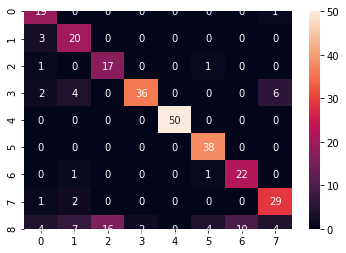

In [18]:
import seaborn as sns
sns.heatmap(conf_matrix,annot=True)

In [19]:
iou_total_sum = 0
for i in range(len(iou_total)):
    iou_total_sum =iou_total_sum + (iou_total[i][0]).sum()/len(iou_total[i][0])
iou_final = iou_total_sum/len(iou_total)

In [20]:
print("Final IOU for validation set : ",iou_final)

Final IOU for validation set :  tensor(0.6520, dtype=torch.float64)
